In [ ]:
import Pkg; using Pkg

#Pkg.add("MLJ")
#Pkg.add("RDatasets")
#Pkg.add("DataFrames")
#Pkg.add("StatsBase")
##Pkg.add("PrettyPrinting")
#Pkg.add("PyPlot")
#Pkg.add("Distances")
# Pkg.add("MLJLinearModels"); 

#Pkg.update()

# Pkg.offline(true) ## try not to get packages from the internet




#### MLJ Demo using the ISL Chap 4 ISL Stock Market data

+ The notebook demonstrates some of the features of the MLJ package by using the Stock Market data from Chap 4 of the ISL book.

+ The Stock Market Data is presented in pages 171 to 189 of the ISL Book. The "smarket" data, as it is named, contains the S&P stock value for 1250 days, from 2001 to 2005. For each day, the percentage values of the 5 previous days, are entered as Lag1 .. Lag5. There is also a column named "Today" and a column named "Volume". There are 9 columns named

```
Year, Lag1, Lag2, Lag3, lag4, Lag5, Volume, Today, Direction

```
The shape of the smarket data is [1250,9]. The first 8 columns contain the independent variables, all numerical, which will form a matrix X of shape [1250,8]. Column 9  in the smarket data is named `Direction`. This is the dependent variable, i.e., this is the variable we need to predict using some of the classification methods available in the MLJ package. The variable `Direction` contains binary values ["Down", "Up"], so eventually those values need to be transformed into `[0,1]`.

+ As a reminder, when  we discussed Classification  Methods in Data Science, we covered 

1. Logistic Regression
2. ISL Lab 4 Part 1 (LDA)
3. ISL Lab 4 Part 2 (QDA)


In [1]:
using MLJ
using RDatasets
using DataFrames
using StatsBase
using PrettyPrinting
using Plots
using Distances
using MLJLinearModels

smarket = dataset("ISLR", "Smarket")
@show size(smarket)
@show names(smarket)

function CheckThreads()
    println("nthreads = ", Threads.nthreads())
end

CheckThreads()

size(smarket) = (1250, 9)
names(smarket) = ["Year", "Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume", "Today", "Direction"]
nthreads = 24


Since we often  want  to only show a few significant digits for the metrics etc, let's introduce a simple function to do that:

In [2]:
r3(x) = round(x, sigdigits=3)
r3(pi)

3.14

Let's get a description of the data too

In [3]:
describe(smarket, :mean, :std, :eltype)

Row,variable,mean,std,eltype
,Symbol,Union…,Union…,DataType
1,Year,2003.02,1.40902,Float64
2,Lag1,0.0038344,1.1363,Float64
3,Lag2,0.0039192,1.13628,Float64
4,Lag3,0.001716,1.1387,Float64
5,Lag4,0.001636,1.13877,Float64
6,Lag5,0.0056096,1.14755,Float64
7,Volume,1.4783,0.360357,Float64
8,Today,0.0031384,1.13633,Float64
9,Direction,,,"CategoricalValue{String, UInt8}"


In [4]:
# println the first 5 rows of the data set
println( smarket[1:5, :])

5×9 DataFrame
 Row │ Year     Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today    Direction 
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Cat…      
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │  2001.0    0.381   -0.192   -2.624   -1.055    5.01    1.1913    0.959  Up
   2 │  2001.0    0.959    0.381   -0.192   -2.624   -1.055   1.2965    1.032  Up
   3 │  2001.0    1.032    0.959    0.381   -0.192   -2.624   1.4112   -0.623  Down
   4 │  2001.0   -0.623    1.032    0.959    0.381   -0.192   1.276     0.614  Up
   5 │  2001.0    0.614   -0.623    1.032    0.959    0.381   1.2057    0.213  Up


### Preparing the data
The independent variables in columns [1..8] will form the X matrix of shape [1250, 1:8].
The dependent variable is Direction. The Direction variable contains categorical two values: "Down", "Up" 
Those values need to be transformed to the numbers 0, 1, and placed in a numerical array named y to compute logit regression.


Some people call this operation **One Shot Encoding**

In [5]:
   
y = map( x -> if x == "Down" 0 elseif x == "Up" 1 end, smarket.Direction)

println(y[1:5])    

X = select(smarket, Not(:Direction));



[1, 1, 0, 1, 1]


We can compute all the pairwise correlations; we use `Matrix` so that the dataframe entries are considered as one matrix of numbers with the same type (otherwise `cor` won't work). 

Note that in the code below, `cm` is a symmetric matrix, in which the diagonals cells have the identity value. 

In [6]:
cm = X |> Matrix |> cor
round.(cm, sigdigits=1)

8×8 Matrix{Float64}:
 1.0    0.03    0.03    0.03    0.04    0.03    0.5    0.03
 0.03   1.0    -0.03   -0.01   -0.003  -0.006   0.04  -0.03
 0.03  -0.03    1.0    -0.03   -0.01   -0.004  -0.04  -0.01
 0.03  -0.01   -0.03    1.0    -0.02   -0.02   -0.04  -0.002
 0.04  -0.003  -0.01   -0.02    1.0    -0.03   -0.05  -0.007
 0.03  -0.006  -0.004  -0.02   -0.03    1.0    -0.02  -0.03
 0.5    0.04   -0.04   -0.04   -0.05   -0.02    1.0    0.01
 0.03  -0.03   -0.01   -0.002  -0.007  -0.03    0.01   1.0

Let's see what the `:Volume` feature looks like:

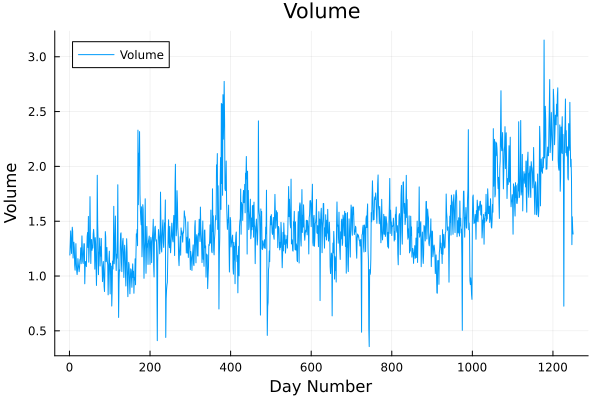

In [8]:

using Plots

# figure(figsize=(8,6))

#xlabel("Tick number", fontsize=14)
#ylabel("Volume", fontsize=14)
#xticks(fontsize=12)
#yticks(fontsize=12)

plot(X.Volume, title="Volume",label="Volume")
xlabel!("Day Number")
ylabel!("Volume")


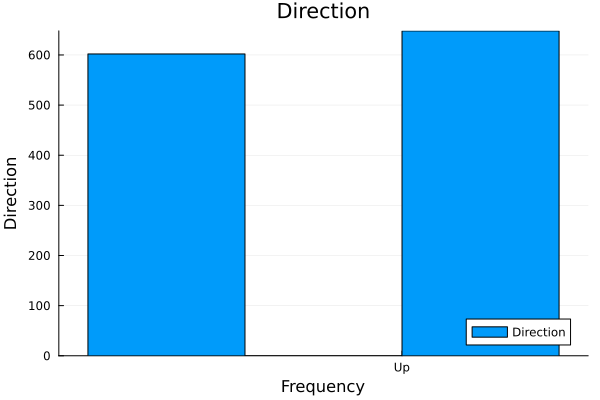

In [9]:
# Looking into Direction shows that "Up" was sightly more frequent than "Down" 
colors = cgrad(:viridis, 2)
bin_colors = colors[1:2]
labels=["Up", "Down"]

histogram(y, title="Direction",label="Direction", bins=2, xticks=(1:2,labels))# , color=bin_colors)
# histogram(y, title="Direction",label="Direction", bins=2, xticks=(labels[1:2]))
xlabel!("Frequency")
ylabel!("Direction")

# display(p)

\figalt{volume}{ISL-lab-4-volume.svg}

### Logistic Regression

We will now train the data using Logistic Regression. The target `:Direction` has two classes: `Up` and `Down`; it needs to be interpreted as a categorical object, and we will mark it as a _ordered factor_ to specify that 'Up' is positive and 'Down' negative (for the confusion matrix later):

In [7]:
y = coerce(y, OrderedFactor)
classes(y[1])
## y is of type "categorical" array. The values that it contains are "Up" and "Down"
@show(typeof(y))
println(y[1:5])

typeof(y) = CategoricalArrays.CategoricalVector{Int64, UInt32, Int64, CategoricalArrays.CategoricalValue{Int64, UInt32}, Union{}}
CategoricalArrays.CategoricalValue{Int64, UInt32}[1, 1, 0, 1, 1]


### Use MLJ Logistic Regression Classifier

Note that at the end we will obtain a ***Confusion Matrix***

Reference:

[https://docs.google.com/presentation/d/1zOikKpq_FGpoptS3rTKSr1s7ILBI_5Dgx0aloXe3j04/edit#slide=id.g2d5e85855c2_0_11]



In [11]:
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels
X2 = select(X, Not([:Year, :Today]))

@show(names(X2))
## Use in X2 only ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]

classif = machine(LogisticClassifier(), X2, y)

fit!(classif)
ŷ = MLJ.predict(classif, X2)
ŷ[1:3]

cross_entropy(ŷ, y) |> mean |> r3

ŷ = predict_mode(classif, X2)
misclassification_rate(ŷ, y) |> r3

cm = confusion_matrix(ŷ, y)


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/juan/.julia/packages/MLJModels/ziReN/src/loading.jl:159


import MLJLinearModels ✔
names(X2) = ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]


┌ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, @NamedTuple{}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: @NamedTuple{} NamedTuple()
└ @ MLJLinearModels /home/juan/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:72


          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 145  │ 141  │
├─────────┼──────┼──────┤
│    1    │ 457  │ 507  │
└─────────┴──────┴──────┘


### Vote of Confidence

The values obtained for the predictions of Logistic Regressions using MLJ are exactly the same as the values in Section 4.72, pp 174 of the ISL Book, where they use the glm() package from "R" 

In [12]:
# To get the fitted parameters of the model 
# coefs = classif.model.coefs

# coefs = classif.fitresult[1].model.coefs
# coefs = classif.fitresult[1].coefs
# coefs = classif.fitresult.model.coefficients

fp = fitted_params(classif)
println(fp)



(classes = CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1], coefs = [:Lag1 => -0.07307919757851809, :Lag2 => -0.04230066449142895, :Lag3 => 0.011086252136277392, :Lag4 => 0.0093613276354277, :Lag5 => 0.010312327997324407, :Volume => 0.13543397415891695], intercept = -0.12599472918896334)


In [13]:
@show false_positive(cm)
@show accuracy(ŷ, y)  |> r3
@show accuracy(cm)    |> r3  # same thing

#@show precision(ŷ, y) |> r3

@show recall(ŷ, y)    |> r3
@show f1score(ŷ, y)   |> r3

train = 1:findlast(X.Year .< 2005)
test = last(train)+1:length(y);

fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)
accuracy(ŷ, y[test]) |> r3

X3 = select(X2, [:Lag1, :Lag2])


classif = machine(LogisticClassifier(), X3, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)
accuracy(ŷ, y[test]) |> r3

Xnew = (Lag1 = [1.2, 1.5], Lag2 = [1.1, -0.8])
ŷ = MLJ.predict(classif, Xnew)
ŷ |> pprint

mode.(ŷ)


false_positive(cm) = 457
accuracy(ŷ, y) |> r3 = 0.522
accuracy(cm) |> r3 = 0.522
recall(ŷ, y) |> r3 = 0.782
f1score(ŷ, y) |> r3 = 0.629


┌ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, @NamedTuple{}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: @NamedTuple{} NamedTuple()
└ @ MLJLinearModels /home/juan/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:72


UnivariateFinite{OrderedFactor{2}, Int64, UInt32, Float64}[UnivariateFinite{OrderedFactor{2}}(0=>0.521, 1=>0.479), UnivariateFinite{OrderedFactor{2}}(0=>0.504, 1=>0.496)]

┌ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, @NamedTuple{}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: @NamedTuple{} NamedTuple()
└ @ MLJLinearModels /home/juan/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:72


2-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0

Note that in this case the default order comes from the lexicographic order which happens  to map  to  our intuition since `D`  comes before `U`.

\fig{ISL-lab-4-bal.svg}

Seems pretty balanced.

Let's now try fitting a simple logistic classifier (aka logistic regression) not using `:Year` and `:Today`:

In [10]:


LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels
X2 = select(X, Not([:Year, :Today]))
@show(names(X2))
classif = machine(LogisticClassifier(), X2, y)

import MLJLinearModels ✔
names(X2) = ["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/juan/.julia/packages/MLJModels/ziReN/src/loading.jl:159


untrained Machine; caches model-specific representations of data
  model: LogisticClassifier(lambda = 2.220446049250313e-16, …)
  args: 
    1:	Source @258 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @597 ⏎ AbstractVector{OrderedFactor{2}}


Let's fit it to the data and try to reproduce the output:

In [11]:
fit!(classif)
ŷ = MLJ.predict(classif, X2)
ŷ[1:3]

┌ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, @NamedTuple{}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: @NamedTuple{} NamedTuple()
└ @ MLJLinearModels /home/juan/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:72


3-element CategoricalDistributions.UnivariateFiniteVector{OrderedFactor{2}, Int64, UInt32, Float64}:
 UnivariateFinite{OrderedFactor{2}}(0=>0.493, 1=>0.507)
 UnivariateFinite{OrderedFactor{2}}(0=>0.519, 1=>0.481)
 UnivariateFinite{OrderedFactor{2}}(0=>0.519, 1=>0.481)

Note that here the `ŷ` are _scores_.
We can recover the average cross-entropy loss:

In [12]:
cross_entropy(ŷ, y) |> mean |> r3

0.691

in order to recover the class, we could use the mode and compare the misclassification rate:

In [13]:
ŷ = predict_mode(classif, X2)
misclassification_rate(ŷ, y) |> r3

0.478

Well that's not fantastic...

Let's visualise how we're doing building a confusion matrix,
first is predicted, second is truth:

In [14]:
cm = confusion_matrix(ŷ, y)

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 145  │ 141  │
├─────────┼──────┼──────┤
│    1    │ 457  │ 507  │
└─────────┴──────┴──────┘


We can then compute the accuracy or precision, etc. easily for instance:

In [15]:
@show false_positive(cm)
@show accuracy(ŷ, y)  |> r3

# @show using Distances accuracy(cm)    |> r3  # same thing

@show accuracy(cm)    |> r3  # same thing
# @show precision(ŷ, y) |> r3
@show recall(ŷ, y)    |> r3
@show f1score(ŷ, y)   |> r3

false_positive(cm) = 457
accuracy(ŷ, y) |> r3 = 0.522
accuracy(cm) |> r3 = 0.522
recall(ŷ, y) |> r3 = 0.782
f1score(ŷ, y) |> r3 = 0.629


0.629

Let's now train on the data before 2005 and use it to predict on the rest.
Let's find the row indices for which the condition holds

In [16]:
train = 1:findlast(X.Year .< 2005)
test = last(train)+1:length(y);

We can now just re-fit the machine that we've already defined just on those rows and predict on the test:

In [17]:
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, @NamedTuple{}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: @NamedTuple{} NamedTuple()
└ @ MLJLinearModels /home/juan/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:72


0.48

Well, that's not very good...
Let's retrain a machine using only `:Lag1` and `:Lag2`:

In [19]:
X3 = select(X2, [:Lag1, :Lag2])
classif = machine(LogisticClassifier(), X3, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, @NamedTuple{}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: @NamedTuple{} NamedTuple()
└ @ MLJLinearModels /home/juan/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:72


0.56

Interesting... it has higher accuracy than the model with more features! This could be investigated further by increasing the regularisation parameter but we'll leave that aside for now.

We can use a trained machine to predict on new data:

In [20]:
Xnew = (Lag1 = [1.2, 1.5], Lag2 = [1.1, -0.8])
ŷ = MLJ.predict(classif, Xnew)
ŷ |> pprint

UnivariateFinite{OrderedFactor{2}, Int64, UInt32, Float64}[UnivariateFinite{OrderedFactor{2}}(0=>0.521, 1=>0.479), UnivariateFinite{OrderedFactor{2}}(0=>0.504, 1=>0.496)]

**Note**: when specifying data, we used a simple `NamedTuple`; we could also have defined a dataframe or any other compatible tabular container.
Note also that we retrieved the raw predictions here i.e.: a score for each class; we could have used `predict_mode` or indeed

In [21]:
mode.(ŷ)

2-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 0
 0

### LDA

Let's do a similar thing but with a LDA model this time:

In [22]:
BayesianLDA = @load BayesianLDA pkg=MultivariateStats

classif = machine(BayesianLDA(), X3, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)

accuracy(ŷ, y[test]) |> r3

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/juan/.julia/packages/MLJModels/ziReN/src/loading.jl:159
┌ Info: Training machine(BayesianLDA(method = gevd, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


0.56

Note: `BayesianLDA` is LDA using a multivariate normal model for each class with a default prior inferred from the proportions for each class in the training data.
You can also use the bare `LDA` model which does not make these assumptions and allows using a different metric in the transformed space, see the docs for details.

In [31]:
LDA = @load LDA pkg=MultivariateStats


classif = machine(LDA(dist=CosineDist()), X3, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)

accuracy(ŷ, y[test]) |> r3

import MLJMultivariateStatsInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/juan/.julia/packages/MLJModels/ziReN/src/loading.jl:159
┌ Info: Training machine(LDA(method = gevd, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


0.548

### QDA

Bayesian QDA is available via ScikitLearn:

In [23]:
BayesianQDA = @load BayesianQDA pkg=ScikitLearn

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/juan/.julia/packages/MLJModels/ziReN/src/loading.jl:159


ArgumentError: ArgumentError: The package "ScikitLearn" does not appear to provide the model "BayesianQDA". 
Use models() to list all models. 

Using it is done in much the same way as before:

In [24]:
classif = machine(BayesianQDA(), X3, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)

accuracy(ŷ, y[test]) |> r3

UndefVarError: UndefVarError: `BayesianQDA` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### KNN

We can use K-Nearest Neighbors models via the [`NearestNeighbors`](https://github.com/KristofferC/NearestNeighbors.jl) package:

In [23]:
KNNClassifier = @load KNNClassifier

knnc = KNNClassifier(K=1)
classif = machine(knnc, X3, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)
accuracy(ŷ, y[test]) |> r3

import NearestNeighborModels ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/juan/.julia/packages/MLJModels/ziReN/src/loading.jl:159


┌ Info: Training machine(KNNClassifier(K = 1, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


0.5

Pretty bad... let's try with three neighbors

In [33]:
knnc.K = 3
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)
accuracy(ŷ, y[test]) |> r3

┌ Info: Updating machine(KNNClassifier(K = 3, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:500


0.532

A bit better but not hugely so.

## Caravan insurance data

The caravan dataset is part of ISLR as well:

In [34]:
caravan  = dataset("ISLR", "Caravan")
size(caravan)

(5822, 86)

The target variable is `Purchase`, effectively  a categorical

In [35]:
purchase = caravan.Purchase
vals     = unique(purchase)

2-element Vector{String}:
 "No"
 "Yes"

Let's see how many of each we have

In [36]:
nl1 = sum(purchase .== vals[1])
nl2 = sum(purchase .== vals[2])
println("#$(vals[1]) ", nl1)
println("#$(vals[2]) ", nl2)

#No 5474
#Yes 348


we can also visualise this as was done before:

In [30]:
figure(figsize=(8,6))
cm = countmap(purchase)
PyPlot.bar([1, 2], [cm["No"], cm["Yes"]])
xticks([1, 2], ["No", "Yes"], fontsize=12)
yticks(fontsize=12)
ylabel("Number of occurences", fontsize=14)

PyObject Text(0, 0.5, 'Number of occurences')

\fig{ISL-lab-4-bal2.svg}

that's quite unbalanced.

Apart from the target, all other variables are numbers; we can standardize the data:

In [31]:
y, X = unpack(caravan, ==(:Purchase), col->true)

mstd = machine(Standardizer(), X)
fit!(mstd)
Xs = MLJ.transform(mstd, X)

var(Xs[:,1]) |> r3

┌ Info: Training machine(Standardizer(features = Symbol[], …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


1.0

**Note**: in MLJ, it is recommended to work with pipelines / networks when possible and not do "step-by-step" transformation and fitting of the data as this is more error prone. We do it here to stick to the ISL tutorial.

We split the data in the first 1000 rows for testing and the rest for training:

In [32]:
test = 1:1000
train = last(test)+1:nrows(Xs);

Let's now fit a KNN model and check the misclassification rate

In [33]:
classif = machine(KNNClassifier(K=3), Xs, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)

accuracy(ŷ, y[test]) |> r3

┌ Info: Training machine(KNNClassifier(K = 3, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499


0.925

that looks good but recall the problem is very unbalanced

In [34]:
mean(y[test] .!= "No") |> r3

0.059

Let's fit a logistic classifier to this problem

In [35]:
classif = machine(LogisticClassifier(), Xs, y)
fit!(classif, rows=train)
ŷ = predict_mode(classif, rows=test)

accuracy(ŷ, y[test]) |> r3

┌ Info: Training machine(LogisticClassifier(lambda = 2.220446049250313e-16, …), …).
└ @ MLJBase /home/juan/.julia/packages/MLJBase/7nGJF/src/machines.jl:499
┌ Info: Solver: LBFGS{Optim.Options{Float64, Nothing}, @NamedTuple{}}
│   optim_options: Optim.Options{Float64, Nothing}
│   lbfgs_options: @NamedTuple{} NamedTuple()
└ @ MLJLinearModels /home/juan/.julia/packages/MLJLinearModels/yYgtO/src/mlj/interface.jl:72


0.934

### ROC and AUC

Since we have a probabilistic classifier, we can also check metrics that take _scores_ into account such as the area under the ROC curve (AUC):

In [36]:
ŷ = MLJ.predict(classif, rows=test)

auc(ŷ, y[test])

0.7388551666996884

We can also display the curve itself

In [ ]:

### The original cell tries to use ROC, a function not added into any of the Julia packages.
### I found a ROC at the URL Below, but unfortunately that pkg/function is not in any of the Julia registries.
##  Therefore I prefer not using it. 

## after that I tried  
# import Pkg; using Pkg; Pkg.add("roc")
## Added ROC via Pkg mng REPL
## Pkg.add("https://github.com/diegozea/ROC.jl");
# using roc

# I found that MLJBase has a functionm named roc_curve that looks like it is what the cell needs


using MLJBase

# Assuming you have predictions and true labels
# roc_curve_data = roc_curve(predictions, true_labels) 

rc = roc_curve( ŷ, y[test])
plt=plot(rc, legend=false)


#fpr = roc_curve_data.NO
#tpr = roc_curve_data.YES


# Calculate AUC
#auc_value = auc(roc_curve_data) 


# fprs, tprs, thresholds = roc(ŷ, y[test])
#figure(figsize=(8,6))
#plot(fprs, tprs)

#xlabel("False Positive Rate", fontsize=14)
#ylabel("True Positive Rate", fontsize=14)
#xticks(fontsize=12)
#yticks(fontsize=12)

┌ Warning: Levels not explicitly ordered. Using the order ["No", "Yes"]. The "positive" level is Yes. 
└ @ StatisticalMeasures /home/juan/.julia/packages/StatisticalMeasures/UTtxb/src/roc.jl:28


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/juan/.julia/packages/PyCall/1gn3u/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Input could not be cast to an at-least-1D NumPy array')
  File "/usr/lib/python3/dist-packages/matplotlib/pyplot.py", line 2748, in plot
    return gca().plot(
           ^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py", line 1668, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_base.py", line 311, in __call__
    yield from self._plot_args(
               ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/matplotlib/axes/_base.py", line 496, in _plot_args
    x, y = index_of(xy[-1])
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py", line 1696, in index_of
    raise ValueError('Input could not be cast to an at-least-1D NumPy array')


\figalt{ROC}{ISL-lab-4-roc.svg}

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*